## 测试一下数据

In [2]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os
import numpy as np

test_wav_file = "H:\\PycharmProjects\\dataset\\data_thchs30\\train\\A2_0.wav"

# fs 采样频率
fs, data = wav.read(test_wav_file)

print(data)
N = len(data)  # 取样点数

Tp = data.shape[0] / fs  # 采样总时长

print(N)
print(fs)
print("time length:", Tp)

[-296 -424 -392 ... -394 -379 -390]
157000
16000
time length: 9.8125


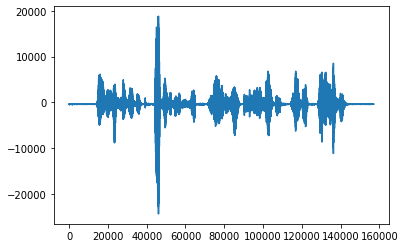

In [2]:
plt.plot(data)
plt.show()

In [3]:
import wave
import pdb

def read_wav_data(filename):
    wav = wave.open(filename,"rb") # 打开一个wav格式的声音文件流
    num_frame = wav.getnframes() # 获取帧数
    num_channel=wav.getnchannels() # 获取声道数
    framerate=wav.getframerate() # 获取帧速率
    num_sample_width=wav.getsampwidth() # 获取实例的比特宽度，即每一帧的字节数
    str_data = wav.readframes(num_frame) # 读取全部的帧
    wav.close() # 关闭流
    wave_data = np.fromstring(str_data, dtype = np.short) # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T # 将矩阵转置
    #wave_data = wave_data 
    return wave_data, framerate  

wave_data, fs = read_wav_data(test_wav_file)
time_window = 25 # 单位ms
window_length = fs / 1000 * time_window # 计算窗长度的公式，目前全部为400固定值
range0_end = int(len(wave_data[0])/fs*1000 - time_window) // 10 + 1
pdb.set_trace()
range0_end

E:\AnaConda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


--Return--
> <ipython-input-3-ba5e0512ea0b>(22)<module>()->None
-> pdb.set_trace()
(Pdb) c


979

## 对数据进行分帧

**分帧**：对语音信号做离散傅里叶变换的时候，不能使用无限制的时长去做变换，必须将语音分成一个个小段，每一段称之为：帧。先将N个采样点集合成一个观测单位，称为帧。通常情况下N的值为256或512，涵盖的时间约为20~30ms左右。为了避免相邻两帧的变化过大，因此会让两相邻帧之间有一段重叠区域，此重叠区域包含了M个取样点，通常M的值约为N的1/2或1/3。通常语音识别所采用语音信号的采样频率为8KHz或16KHz，以8KHz来说，若帧长度为256个采样点，则对应的时间长度是256/8000×1000=32ms。

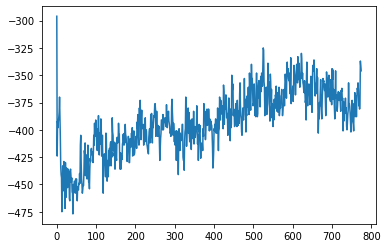

In [4]:
time_window = 25
fft_size = 512
window_length = fs // fft_size * time_window

p_begin = 0
p_end = p_begin + window_length
frame = data[p_begin: p_end]
plt.plot(frame)
plt.show()

## 给数据添加海明窗

若时间无限，频带有限，由于离散DFT只能计算有限时间的频谱，所以会出现**泄漏现象**。

采取的措施：选择合适的窗函数和宽度。可以选择的窗函数有：汉宁窗、海明窗、布莱克曼窗等。我们期望的窗函数是：主瓣宽度越小越好，旁瓣宽度越大越好。

先计算在指定帧长（25ms）内采样的数目M，这是海明窗需要的唯一参数

加窗在时域中就是窗函数和时域函数的乘积，在频域就是卷积。

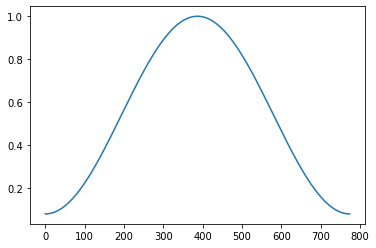

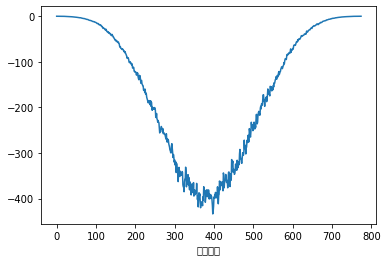

In [17]:
import numpy as np

M = int(N / (Tp * fft_size)) * time_window
w = np.hamming(M)
plt.plot(w)
plt.show()

frame = frame * w
plt.xlabel(u"取样点数")
plt.plot(frame)
plt.show()

## 傅里叶变换

傅里叶变换求得幅值，然后取对数得到数值比较大的值

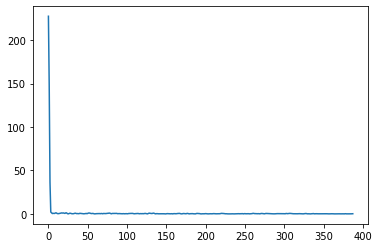

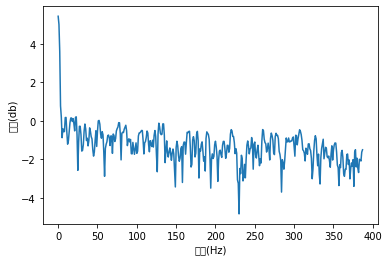

In [18]:
from scipy.fftpack import fft

# 进行快速傅里叶变换
frame_fft = np.abs(np.fft.rfft(frame)/fft_size)
plt.plot(frame_fft)
plt.show()

# 取对数，求db
frame_log = np.log(np.clip(frame_fft, 1e-20, 1e100))
plt.xlabel(u"赫兹(Hz)")
plt.ylabel(u"幅值(db)")
plt.plot(frame_log)
plt.show()

## 完整的将WAV音频文件转成需要的语音特征

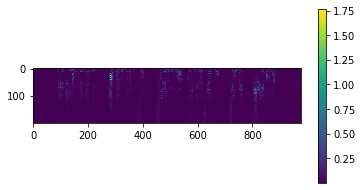

In [16]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os
import numpy as np
import pdb

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

def compute_freq_feature(wav_file):
    # fs 采样频率
    fs, data = wav.read(test_wav_file)
    N = len(data)  # 取样点数
    Tp = data.shape[0] / fs  # 采样总时长
    
    time_window = 25
    fft_size = 512
    window_length = int(fs / 1000 * time_window)  #400

    range0_end = int(Tp * 1000 - time_window) // 10 
    data_input = np.zeros((range0_end, window_length//2), dtype = np.float) # 用于存放最终的频率特征数据
    data_line = np.zeros((1, window_length), dtype = np.float)
    for i in range(0, range0_end):
        p_begin = i * 160  #两相邻帧之间有一段重叠区域
        p_end = p_begin + 400
        frame = data[p_begin: p_end]
        
        w = np.hamming(len(frame))
        frame = frame * w
    
#         pdb.set_trace()
#         print("frame :", frame)
        # 进行快速傅里叶变换
        frame_fft = np.fft.rfft(frame)/N

        # 取对数
        frame_log =  np.log(np.abs(frame_fft) + 1)
#         frame_log =  50 * np.log10(np.clip(np.abs(frame_fft), 1e-20, 1e100))
        
        data_input[i] = frame_log[:window_length//2]
        
    return data_input


freimg = compute_freq_feature(test_wav_file)
freimg = freimg.T
plt.imshow(freimg)
plt.colorbar(cax=None,ax=None,shrink=0.8)  
plt.show() 



E:\AnaConda\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


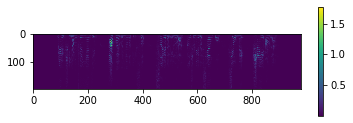

In [3]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
import wave
from scipy.fftpack import fft


def read_wav_data(filename):
    '''
    读取一个wav文件，返回声音信号的时域谱矩阵和播放时间
    '''
    wav = wave.open(filename, "rb")  # 打开一个wav格式的声音文件流
    num_frame = wav.getnframes()  # 获取帧数
    num_channel = wav.getnchannels()  # 获取声道数
    framerate = wav.getframerate()  # 获取帧速率
    num_sample_width = wav.getsampwidth()  # 获取实例的比特宽度，即每一帧的字节数
    str_data = wav.readframes(num_frame)  # 读取全部的帧
    wav.close()  # 关闭流
    wave_data = np.fromstring(str_data, dtype=np.short)  # 将声音文件数据转换为数组矩阵形式
    wave_data.shape = -1, num_channel  # 按照声道数将数组整形，单声道时候是一列数组，双声道时候是两列的矩阵
    wave_data = wave_data.T  # 将矩阵转置
    # wave_data = wave_data
    return wave_data, framerate

x=np.linspace(0, 400 - 1, 400, dtype = np.int64)
w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1) ) # 汉明窗
def GetFrequencyFeature4(wavsignal, fs):
    if (16000 != fs):
        raise ValueError(
            '[Error] ASRT currently only supports wav audio files with a sampling rate of 16000 Hz, but this audio is ' + str(
                fs) + ' Hz. ')

    # wav波形 加时间窗以及时移10ms
    time_window = 25  # 单位ms
    window_length = int(fs / 1000 * time_window)  # 计算窗长度的公式，目前全部为400固定值

    wav_arr = np.array(wavsignal)
    # wav_length = len(wavsignal[0])
    wav_length = wav_arr.shape[1]

    range0_end = int(len(wavsignal[0]) / fs * 1000 - time_window) // 10 + 1  # 计算循环终止的位置，也就是最终生成的窗数
    data_input = np.zeros((range0_end, window_length // 2), dtype=np.float)  # 用于存放最终的频率特征数据
    data_line = np.zeros((1, window_length), dtype=np.float)

    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400

        data_line = wav_arr[0, p_start:p_end]
        data_line = data_line * w  # 加窗

        data_line = np.abs(fft(data_line)) / wav_length

        data_input[i] = data_line[0: window_length // 2]  # 设置为400除以2的值（即200）是取一半数据，因为是对称的

    data_input = np.log(data_input + 1)
    return data_input


data, fs = read_wav_data(test_wav_file)
freimg = GetFrequencyFeature4(data, fs)
freimg = freimg.T
plt.imshow(freimg)
plt.colorbar(cax=None, ax=None, shrink=0.5)
plt.show()